![logo](./img/logos/logo.png)

<h1 style='text-align: center'><b>Previsão de Risco de Crédito com Python</b></h1>

<h3 style='text-align: center'>Workflow do Projeto</h3>

![worflow](./img/workflow/projeto.png)

## Bibliotecas

In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.utils import resample
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from scipy.stats import f_oneway
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from statsmodels.stats.multicomp import  MultiComparison

import warnings
warnings.filterwarnings('ignore')

## Funções

In [2]:
def agrupa_dados(dados:pd.DataFrame,variavel:str,intervalo:list,agrupamento:str) -> pd.DataFrame:
    '''Agrupa os dados de um atributo por intervalos e retorna um pandas.DataFrame'''
    # Lista para armazenar os resultados
    resultados = []
    
    tamanho = len(intervalo)
    
    for x in range(0, tamanho - 1):
        proximo = intervalo[x] + 1
        num_pessoa = dados[variavel].between(proximo, intervalo[x + 1]).sum()
        resultados.append({agrupamento: f'{proximo} - {intervalo[x + 1]}', 'Contagem Total': num_pessoa})

    # Criar DataFrame
    dados_agrupado = pd.DataFrame(resultados)

    return dados_agrupado

In [3]:
def validacao_cruzada(algoritmo, base_treino_x:list[list[list]],base_treino_y:list[list[list]]) -> dict:
    '''Retorna um dicionário com as pontuações das metricas apontadas no cross_validate.'''
    accuracy = []
    precision = []
    recall = []

    for i in range(10):
        kfold = KFold(n_splits=5, shuffle=True, random_state=i)
        scores = cross_validate(algoritmo, base_treino_x, base_treino_y, cv=kfold,
                                   scoring=['accuracy', 'precision', 'recall'])
        accuracy.append(scores['test_accuracy'].mean())
        precision.append(scores['test_precision'].mean())
        recall.append(scores['test_recall'].mean())

    resultados = {'accuracy':accuracy, 'precision':precision, 'recall':recall}

    return resultados

In [4]:
def matriz_confusao(cm:np.array) -> None:
    '''Retorna o gráfico da matriz de confusão.'''
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Previsão')
    plt.ylabel('Real')
    plt.title('Matriz de Confusão')
    plt.show()

## Carga dos Dados e Análise Exploratória

In [5]:
# Carregando dataset
dados = pd.read_csv("./dados/credit_risk_dataset.csv")

In [6]:
# Visualizando as 10 primeiras linhas
dados.head(10)

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4
5,21,9900,OWN,2.0,VENTURE,A,2500,7.14,1,0.25,N,2
6,26,77100,RENT,8.0,EDUCATION,B,35000,12.42,1,0.45,N,3
7,24,78956,RENT,5.0,MEDICAL,B,35000,11.11,1,0.44,N,4
8,24,83000,RENT,8.0,PERSONAL,A,35000,8.90,1,0.42,N,2
9,21,10000,OWN,6.0,VENTURE,D,1600,14.74,1,0.16,N,3


In [7]:
# Visualizando as 10 últimas linhas
dados.tail(10)

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
32571,60,45600,RENT,1.0,VENTURE,B,20000,10.00,1,0.44,N,26
32572,52,52000,OWN,0.0,PERSONAL,A,9600,8.49,0,0.18,N,22
32573,56,90000,MORTGAGE,0.0,PERSONAL,A,7200,6.17,0,0.08,N,19
32574,52,65004,RENT,4.0,PERSONAL,D,20000,15.58,1,0.31,Y,19
32575,52,64500,RENT,0.0,EDUCATION,B,5000,11.26,0,0.08,N,20
32576,57,53000,MORTGAGE,1.0,PERSONAL,C,5800,13.16,0,0.11,N,30
32577,54,120000,MORTGAGE,4.0,PERSONAL,A,17625,7.49,0,0.15,N,19
32578,65,76000,RENT,3.0,HOMEIMPROVEMENT,B,35000,10.99,1,0.46,N,28
32579,56,150000,MORTGAGE,5.0,PERSONAL,B,15000,11.48,0,0.10,N,26
32580,66,42000,RENT,2.0,MEDICAL,B,6475,9.99,0,0.15,N,30


In [8]:
# Variáveis da base de dados
dados.columns

Index(['person_age', 'person_income', 'person_home_ownership',
       'person_emp_length', 'loan_intent', 'loan_grade', 'loan_amnt',
       'loan_int_rate', 'loan_status', 'loan_percent_income',
       'cb_person_default_on_file', 'cb_person_cred_hist_length'],
      dtype='object')

In [9]:
# Dimensões da base de dados
dados.shape

(32581, 12)

In [10]:
# Informações dos dados da base
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


In [11]:
# Verificando dados nulos
dados.isnull().sum()

person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              895
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3116
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64

In [12]:
# Verificando dados únicos
dados.nunique()

person_age                      58
person_income                 4295
person_home_ownership            4
person_emp_length               36
loan_intent                      6
loan_grade                       7
loan_amnt                      753
loan_int_rate                  348
loan_status                      2
loan_percent_income             77
cb_person_default_on_file        2
cb_person_cred_hist_length      29
dtype: int64

In [13]:
# Dados da variável alvo loan_status
dados.loan_status.unique()

array([1, 0], dtype=int64)

In [14]:
# Contagem dos registros da vareável alvo loan_status
dados.loan_status.value_counts()

loan_status
0    25473
1     7108
Name: count, dtype: int64

**Distribuição dos dados da variável alvo.**

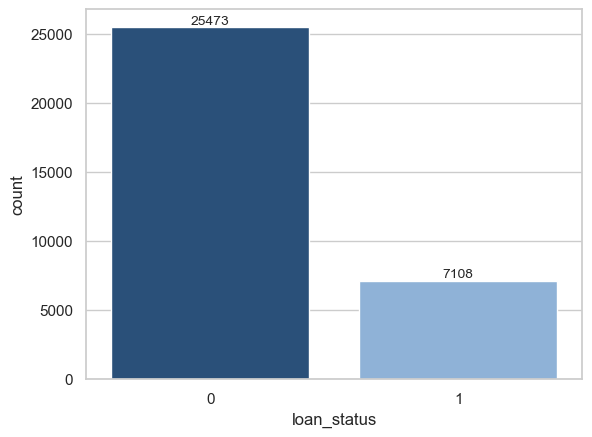

In [15]:
# Visualizando os dados da variável alvo loan_status
sns.set(style='whitegrid')
ax = sns.countplot(x = dados.loan_status, palette=['#1d4f86', '#83b1e3'])
ax.bar_label(ax.containers[0], fontsize=10)
plt.show()

>A variável alvo do conjunto de dados é "loan_status", que possui duas categorias: 0, indicando que o indivíduo pagou o empréstimo, e 1, indicando que não pagou. Registramos **25.473** ocorrências para a categoria 0 em comparação com **7.108** para a categoria 1. Isso sugere, inicialmente, que a maioria dos clientes que adquiriram empréstimos efetuaram os pagamentos. No entanto, também revela um desequilíbrio nos dados, indicando a necessidade de realizar ações para balancear as amostras.

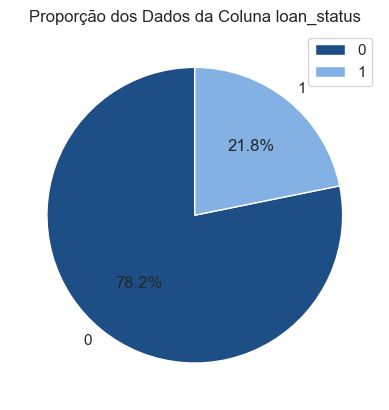

In [16]:
# Visualizando proporções dos dados loan_status
dados['loan_status'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, colors=['#1d4f86', '#83b1e3'])
plt.title('Proporção dos Dados da Coluna loan_status')
plt.ylabel("")
plt.legend(loc='upper right')
plt.show()

>É possível notar que a taxa de inadimplência é de 21,8%, enquanto a de adimplência é de 78,2%. Em outras palavras, cerca de 21,8% dos empréstimos concedidos não foram honrados.

**Total de clientes por faixa etária.**

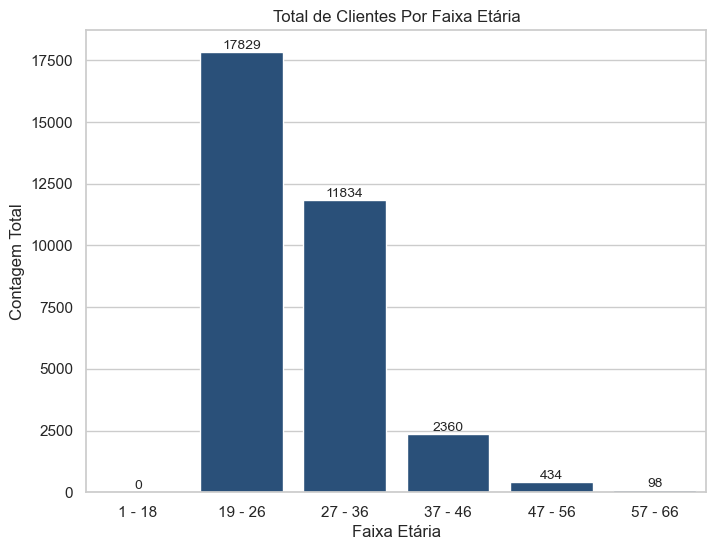

In [17]:
# Intervalos de idades
idades = [0, 18, 26, 36, 46, 56, 66]

# Criando dataframe
idades_agrupadas = agrupa_dados(dados, 'person_age', idades, 'Faixa Etária')

# Visualizando os dados
plt.figure(figsize=(8,6))
sns.set(style='whitegrid')
ax = sns.barplot(idades_agrupadas, x='Faixa Etária', y='Contagem Total', palette=['#1d4f86'])
ax.bar_label(ax.containers[0], fontsize=10)
plt.title('Total de Clientes Por Faixa Etária')
plt.show()

>Podemos notar que há **17.829** registros na faixa etária de **19 a 26 anos**, enquanto para a faixa de **27 a 36 anos**, temos um total de **11.834**. Pode-se afirmar que a maior concentração de clientes está situada nessa faixa etária de **19 a 36 anos**.

**Total de clientes por faixa de renda.**

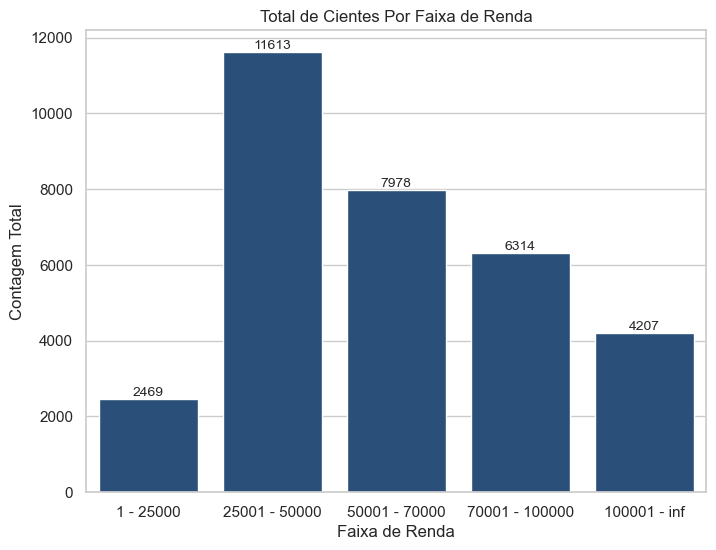

In [18]:
# Intervalos de renda anual
renda = [0, 25000, 50000, 70000, 100000, float('inf')]

# Criando dataframe
renda_agrupada = agrupa_dados(dados, 'person_income', renda, 'Faixa de Renda')

# Plotar o gráfico de barras
plt.figure(figsize=(8,6))
sns.set(style='whitegrid')
ax = sns.barplot(renda_agrupada, x='Faixa de Renda', y='Contagem Total', palette=['#1d4f86'])
ax.bar_label(ax.containers[0], fontsize=10)
plt.title('Total de Cientes Por Faixa de Renda')
plt.show()

>Notamos que aproximadamente **11.613** clientes que adquiriram empréstimos possuem uma renda anual na faixa de **25.000 a 50.000**.

**Total de clientes por faixa de valor de empréstimo.**

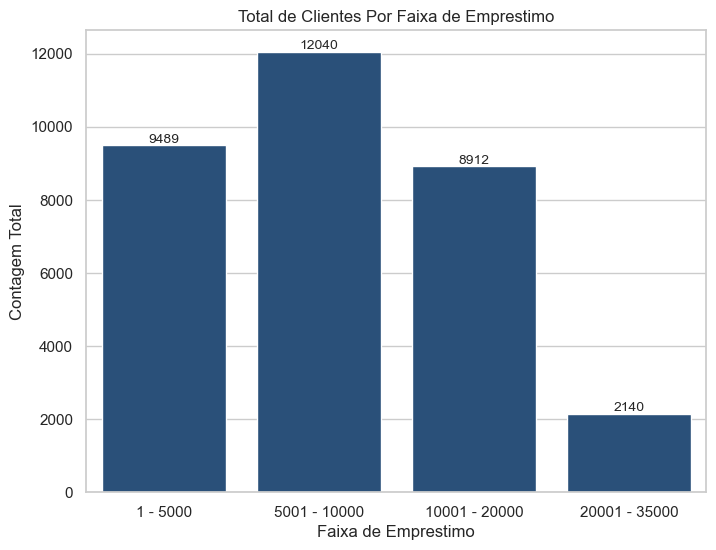

In [19]:
# Intervalos de emprestimos
emprestimo = [0, 5000, 10000, 20000, 35000]

# Criando dataframe
emprestimo_agrupado = agrupa_dados(dados, 'loan_amnt', emprestimo, 'Faixa de Emprestimo')

# Visualizando gráfico
plt.figure(figsize=(8,6))
sns.set(style='whitegrid')
ax = sns.barplot(emprestimo_agrupado, x='Faixa de Emprestimo', y='Contagem Total', palette=['#1d4f86'])
ax.bar_label(ax.containers[0], fontsize=10)
plt.title('Total de Clientes Por Faixa de Emprestimo')
plt.show()

>Percebemos que os valores de empréstimo mais frequentemente contratados situam-se na faixa de **5.000 a 10.000**.

**Distribuição de Status do Empréstimo por Faixa Etária.**

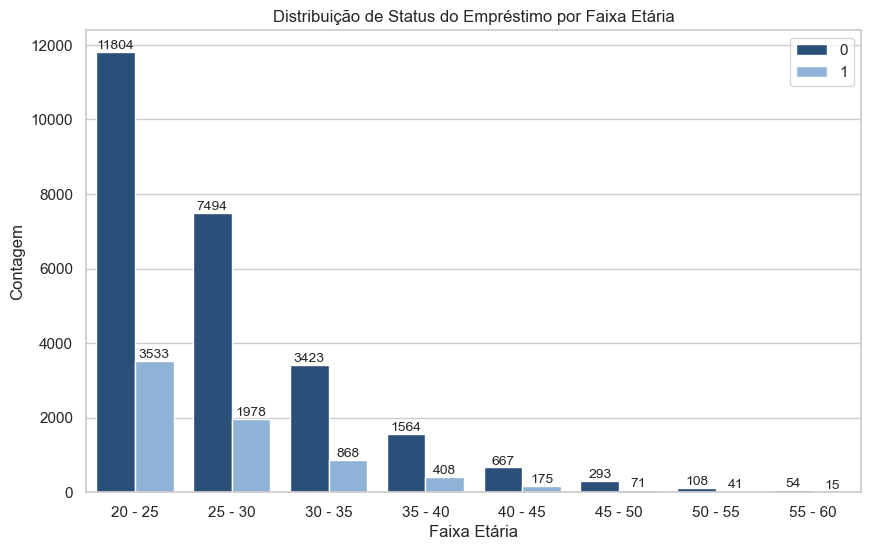

In [20]:
# Copiando base
copia_dados = dados.copy()

# Criando faixas etárias
bins = [20, 25, 30, 35, 40, 45, 50, 55, 60]

# Adicionando uma coluna
copia_dados['faixa_etaria'] = pd.cut(copia_dados['person_age'], bins)

# Criando o gráfico de barras
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")
ax = sns.countplot(copia_dados, x='faixa_etaria', hue='loan_status', palette=['#1d4f86', '#83b1e3'])
ax.bar_label(ax.containers[0], fontsize=10)
ax.bar_label(ax.containers[1], fontsize=10)
plt.xlabel('Faixa Etária')
plt.ylabel('Contagem')
plt.title('Distribuição de Status do Empréstimo por Faixa Etária')
ax.set_xticklabels([f'{left} - {right}' for left, right in zip(bins[:-1], bins[1:])])
plt.legend()
plt.show()

>Podemos notar que à medida que a idade aumenta, a quantidade de empréstimos diminui, sendo que os clientes entre **20 a 30** anos, em sua maioria, cumpriram suas dívidas.

**Distribuição de Status do Empréstimo por Faixa de Renda Anual.**

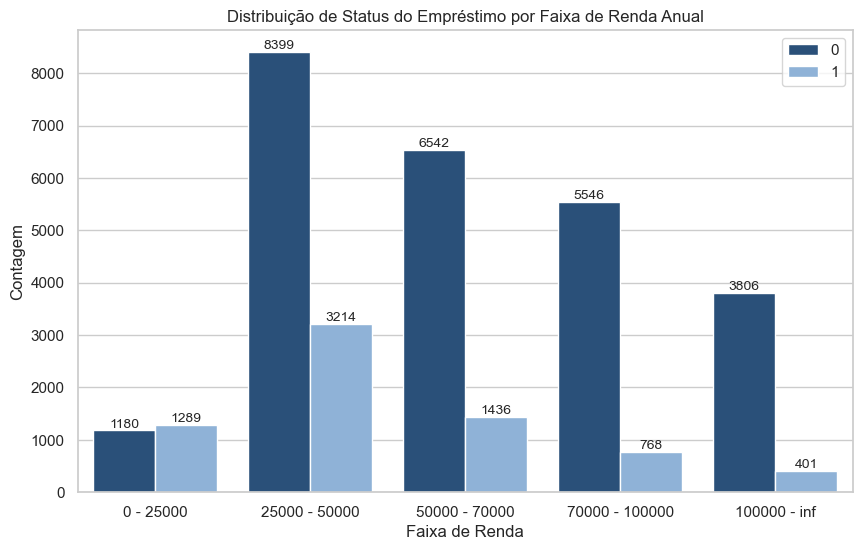

In [21]:
# Copiando base
copia_dados = dados.copy()

# Criando faixas renda
bins = [0, 25000, 50000, 70000, 100000, float('inf')]

# Adicionando uma coluna ao DataFrame
copia_dados['faixa_renda'] = pd.cut(copia_dados['person_income'], bins)

# Criando o gráfico de barras
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")
ax = sns.countplot(copia_dados, x='faixa_renda', hue='loan_status', palette=['#1d4f86', '#83b1e3'])
ax.bar_label(ax.containers[0], fontsize=10)
ax.bar_label(ax.containers[1], fontsize=10)
plt.xlabel('Faixa de Renda')
plt.ylabel('Contagem')
plt.title('Distribuição de Status do Empréstimo por Faixa de Renda Anual')
ax.set_xticklabels([f'{primeiro} - {segundo}' for primeiro, segundo in zip(bins[:-1], bins[1:])])
plt.legend()
plt.show()

>Os clientes com renda entre **0-25.000** destacam-se, pois exibem um maior número de registros nos quais os clientes não cumpriram com o empréstimo em comparação com aqueles que honraram. Nas demais faixas de renda, a adimplência permanece estável.

**Distribuição de Status do Empréstimo por Faixa de Empréstimo.**

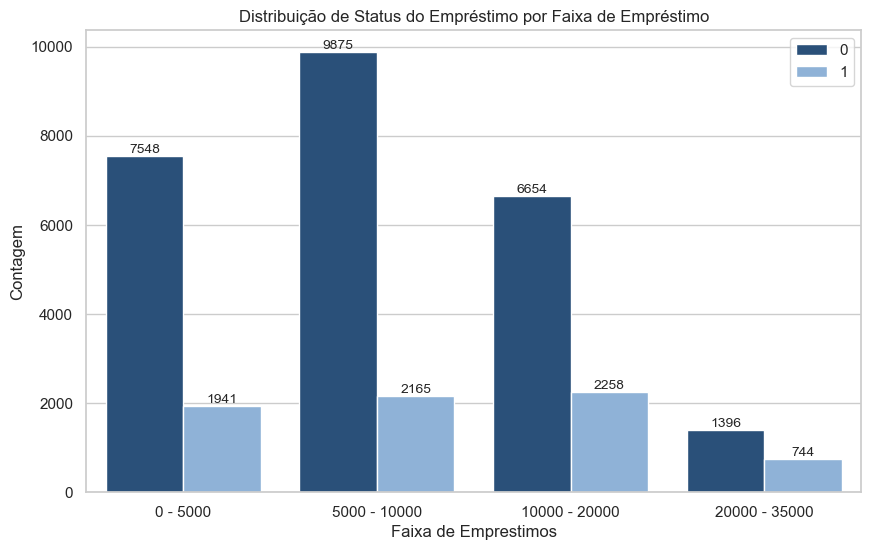

In [22]:
# Copiando base
copia_dados = dados.copy()

# Criando faixas emprestimo
bins = [0, 5000, 10000, 20000, 35000]

# Adicionando uma coluna ao DataFrame
copia_dados['faixa_emprestimo'] = pd.cut(copia_dados['loan_amnt'], bins)

# Criando o gráfico de barras
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")
ax = sns.countplot(copia_dados, x='faixa_emprestimo', hue='loan_status', palette=['#1d4f86', '#83b1e3'])
ax.bar_label(ax.containers[0], fontsize=10)
ax.bar_label(ax.containers[1], fontsize=10)
plt.xlabel('Faixa de Emprestimos')
plt.ylabel('Contagem')
plt.title('Distribuição de Status do Empréstimo por Faixa de Empréstimo')
ax.set_xticklabels([f'{primeiro} - {segundo}' for primeiro, segundo in zip(bins[:-1], bins[1:])])
plt.legend()
plt.show()

>A maioria dos empréstimos, especialmente na faixa de **5.000 a 10.000**, registra uma elevada taxa de clientes que cumpriram com suas obrigações de pagamento.

**Distribuição de Status do Empréstimo por Tipo de Imóvel.**

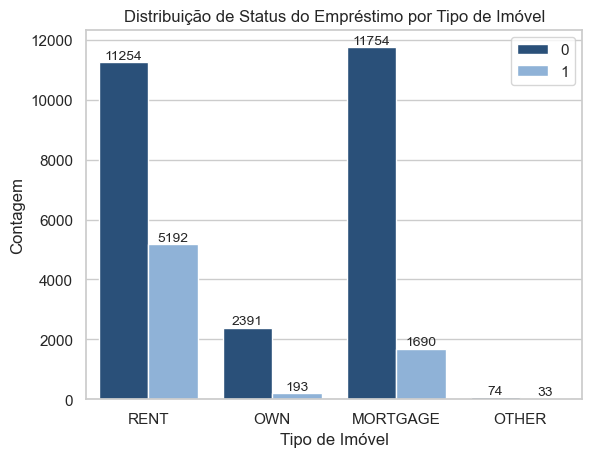

In [23]:
# Criando gráfico
sns.set(style='whitegrid')
ax = sns.countplot(dados, x='person_home_ownership', hue='loan_status', palette=['#1d4f86', '#83b1e3'])
ax.bar_label(ax.containers[0], fontsize=10)
ax.bar_label(ax.containers[1], fontsize=10)
plt.xlabel('Tipo de Imóvel')
plt.ylabel('Contagem')
plt.title('Distribuição de Status do Empréstimo por Tipo de Imóvel')
plt.legend()
plt.show()

>A maioria dos clientes que adquiriu empréstimos está na categoria de aluguel **(RENT)** ou possui uma hipoteca **(MORTGAGE)** em suas residências. Notavelmente, aqueles com residência própria **(OWN)** ou hipoteca **(MORTGAGE)** apresentam uma taxa de inadimplência inferior em comparação com os demais.

**Distribuição de Status do Empréstimo por Histórico de Inadimplência.**

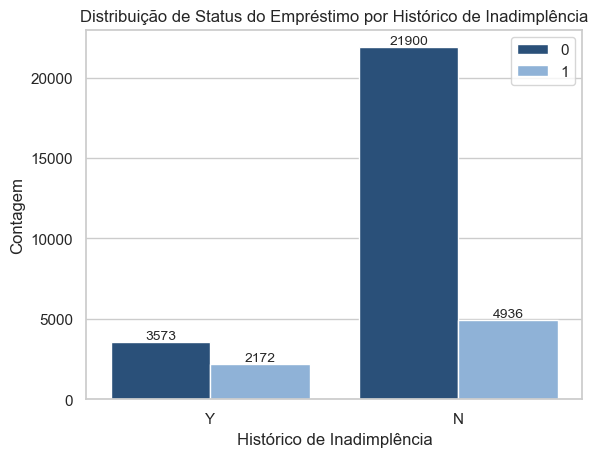

In [24]:
# Criando gráfico
sns.set(style='whitegrid')
ax = sns.countplot(dados, x='cb_person_default_on_file', hue='loan_status', palette=['#1d4f86', '#83b1e3'])
ax.bar_label(ax.containers[0], fontsize=10)
ax.bar_label(ax.containers[1], fontsize=10)
plt.xlabel('Histórico de Inadimplência')
plt.ylabel('Contagem')
plt.title('Distribuição de Status do Empréstimo por Histórico de Inadimplência')
plt.legend()
plt.show()

>Clientes sem histórico de inadimplência **(N)** têm uma proporção reduzida de inadimplência em comparação com aqueles que pagaram o empréstimo. Por outro lado, os clientes com histórico **(Y)** registraram um número ligeiramente superior a 1.000 pagamentos em relação aos não pagamentos.

**Distribuição de Status do Empréstimo por Grau de Empréstimo.**

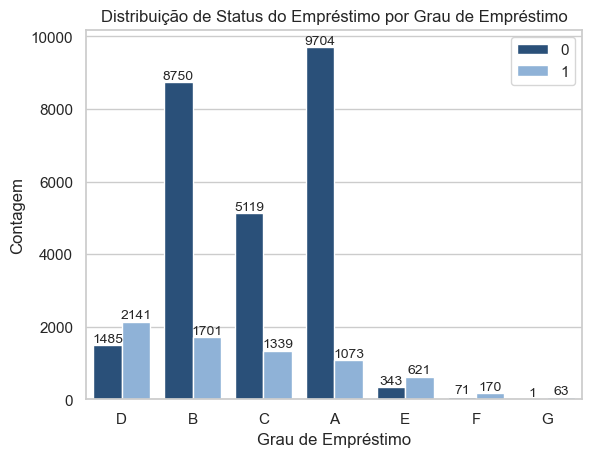

In [25]:
# Criando gráfico
sns.set(style='whitegrid')
ax = sns.countplot(dados, x='loan_grade', hue='loan_status', palette=['#1d4f86', '#83b1e3'])
ax.bar_label(ax.containers[0], fontsize=10)
ax.bar_label(ax.containers[1], fontsize=10)
plt.xlabel('Grau de Empréstimo')
plt.ylabel('Contagem')
plt.title('Distribuição de Status do Empréstimo por Grau de Empréstimo')
plt.legend()
plt.show()

>Observa-se que os clientes que estão entre os graus A, B e C apresentaram um total de clientes adimplentes maior que os inadimplentes, já os que estão entre os graus D, E, F e G apresentaram um total de clientes inadimplentes maior que os adimplentes, então podemos concluir que os clientes categorizados como A, B e C são de baixo risco enquanto os D, E, F e G são de alto risco.

**Distribuição de Status do Empréstimo por Finalidade**

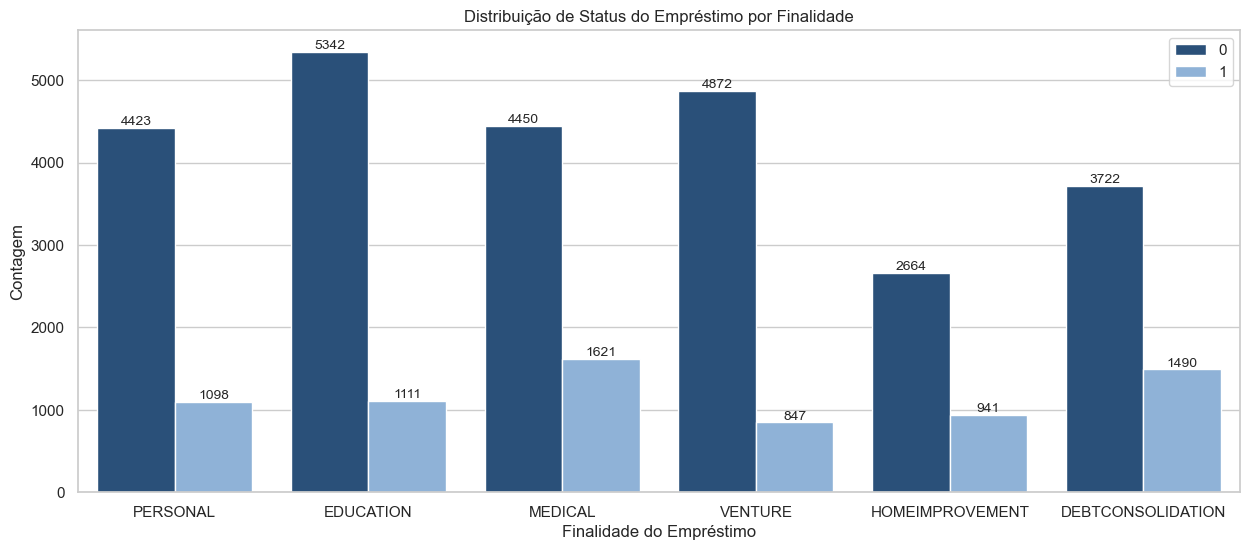

In [26]:
# Criando gráfico
plt.figure(figsize=(15,6))
sns.set(style='whitegrid')
ax = sns.countplot(dados, x='loan_intent', hue='loan_status', palette=['#1d4f86', '#83b1e3'])
ax.bar_label(ax.containers[0], fontsize=10)
ax.bar_label(ax.containers[1], fontsize=10)
plt.xlabel('Finalidade do Empréstimo')
plt.ylabel('Contagem')
plt.title('Distribuição de Status do Empréstimo por Finalidade')
plt.legend()
plt.show()

>Os clientes que contrataram empréstimos VENTURE (empreendimento) tem a menor taxa de inadimplência que todas as outras finalidades e a EDUCATION (educação) tem a maior quantidade de contratos de empréstimos e a maior quantidade de clientes adimplentes.

**Distribuição de Status do Empréstimo por Histórico de Crédito.**

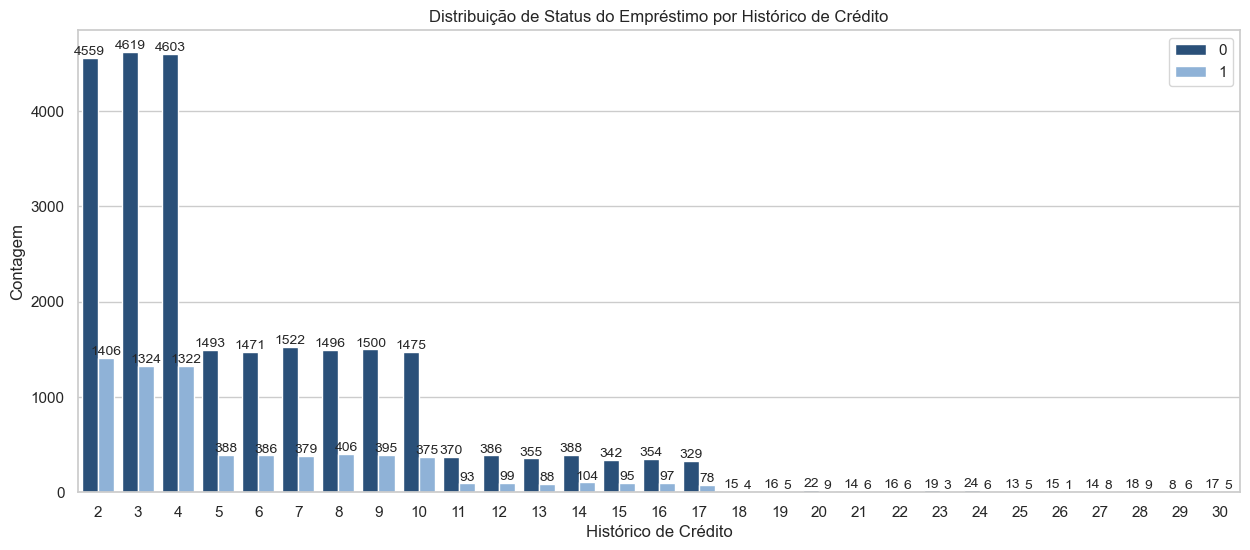

In [27]:
# Criando gráfico
plt.figure(figsize=(15,6))
sns.set(style='whitegrid')
ax = sns.countplot(dados, x='cb_person_cred_hist_length', hue='loan_status', palette=['#1d4f86', '#83b1e3'])
ax.bar_label(ax.containers[0], fontsize=10)
ax.bar_label(ax.containers[1], fontsize=10)
plt.xlabel('Histórico de Crédito')
plt.ylabel('Contagem')
plt.title('Distribuição de Status do Empréstimo por Histórico de Crédito')
plt.legend()
plt.show()

>Podemos perceber que enquanto o tempo de histórico de crédito aumenta diminui a quantidade de clientes inadimplentes e que os clientes com até 4 anos são os que mais contrataram empréstimos.

## Tratando Valores Nulos e Outliers

### Tratando Valores Nulos

In [28]:
# Verificando valores nulos
dados.isnull().sum()

person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              895
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3116
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64

>Encontramos **895** registros ausentes em `person_emp_length` e **3.116** registros ausentes em `loan_int_rate`. Vamos abordar esses valores faltantes utilizando a mediana de cada conjunto nas suas respectivas colunas.

In [29]:
# Mediana dos valores da coluna person_emp_length
dados.person_emp_length.median()

4.0

In [30]:
# Tratando nulos da variável person_emp_length com a mediana dos valores
dados['person_emp_length'].fillna(4.0, inplace=True)

In [31]:
# Mediana dos valores da coluna loan_int_rate
dados.loan_int_rate.median()

10.99

In [32]:
# Tratando nulos da variável loan_int_rate com a mediana dos valores
dados['loan_int_rate'].fillna(10.99,inplace=True)

In [33]:
# Verificando dados nulos
dados.isnull().sum()

person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_status                   0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
dtype: int64

### Análise e Tratamento de Outliers

#### Variável person_age

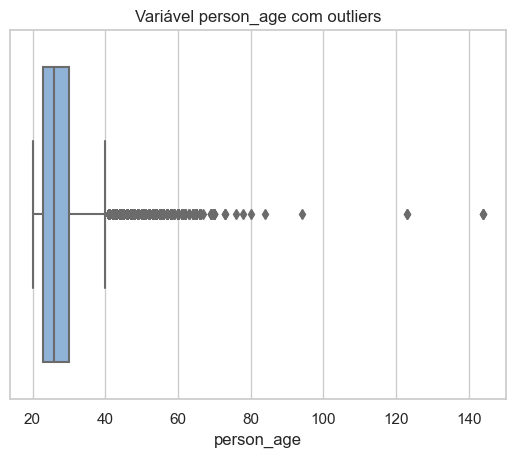

In [34]:
# Visualizando boxplot person_age
sns.boxplot(x=dados['person_age'], color='#83b1e3')
plt.title('Variável person_age com outliers')
plt.show()

>Optamos por excluir registros de pessoas com mais de 60 anos, visando trabalhar com um conjunto de dados mais coeso.

In [35]:
# Retirando registros acima de 80 anos
dados = dados.drop(dados[dados['person_age'] > 60].index, axis=0)

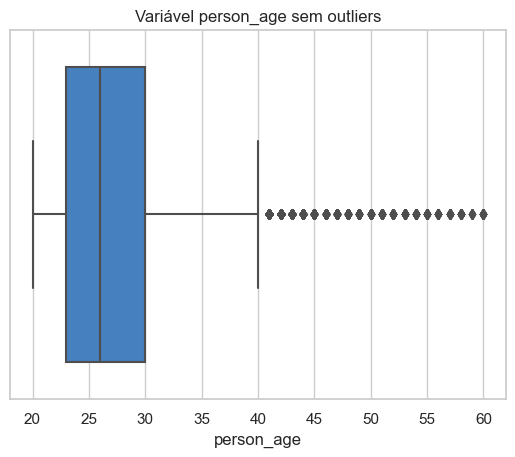

In [36]:
# Visualizando boxplot person_age
sns.boxplot(x=dados['person_age'], color='#327fd2')
plt.title('Variável person_age sem outliers')
plt.show()

#### Variável person_income

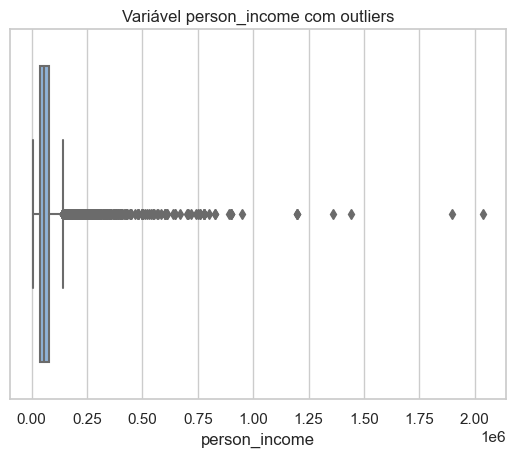

In [37]:
# Visualizando boxplot person_income
sns.boxplot(x=dados['person_income'], color='#83b1e3')
plt.title('Variável person_income com outliers')
plt.show()

>Decidimos excluir registros de renda anual superior a 140.000, com o objetivo de trabalhar com um conjunto de dados mais homogêneo e evitar influências atípicas que possam distorcer a análise.

In [38]:
# Retirando registros acima de 140.000
dados = dados.drop(dados[dados['person_income'] > 140000].index, axis=0)

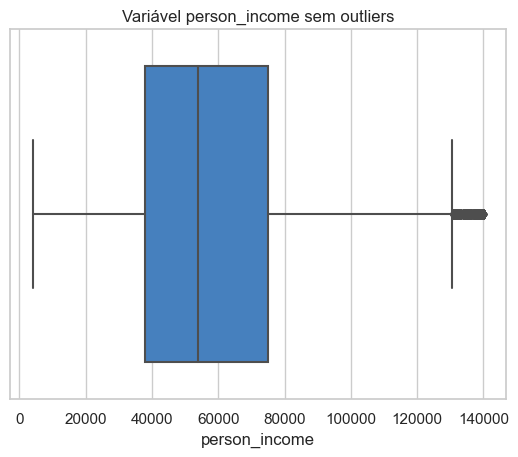

In [39]:
# Visualizando boxplot person_income
sns.boxplot(x=dados['person_income'], color='#327fd2')
plt.title('Variável person_income sem outliers')
plt.show()

#### Variável person_emp_length

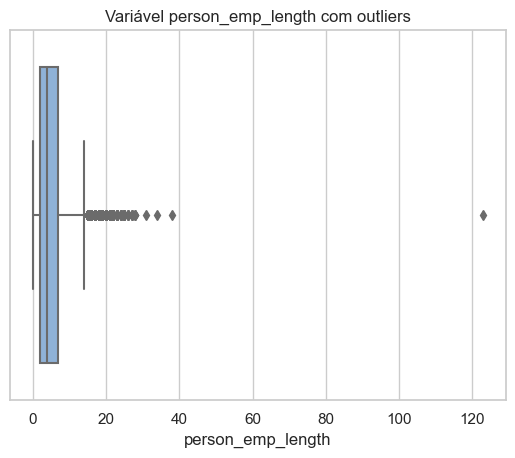

In [40]:
# Visualizando boxplot person_emp_length
sns.boxplot(x=dados['person_emp_length'], color='#83b1e3')
plt.title('Variável person_emp_length com outliers')
plt.show()

>Optamos por excluir registros com tempo de trabalho superior a 30 anos para manter a consistência e relevância do conjunto de dados.

In [41]:
# Consulta dos valores acima de 30 anos de emprego
dados[dados['person_emp_length'] > 30]

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
30914,48,70000,MORTGAGE,31.0,HOMEIMPROVEMENT,D,9000,14.54,0,0.13,N,17
32428,58,49000,MORTGAGE,34.0,MEDICAL,D,7500,13.55,1,0.15,Y,24
32515,53,106000,MORTGAGE,38.0,PERSONAL,B,20000,9.88,0,0.19,N,23


In [42]:
# Retirando registros acima de 30 anos
dados = dados.drop(dados[dados['person_emp_length'] > 30].index, axis=0)

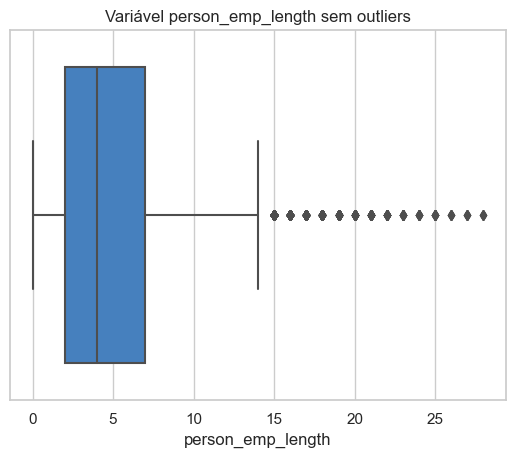

In [43]:
# Visualizando boxplot person_emp_length
sns.boxplot(x=dados['person_emp_length'], color='#327fd2')
plt.title('Variável person_emp_length sem outliers')
plt.show()

### Salvando Base Final

In [44]:
dados.to_csv('./dados/credit_risk_transformada.csv', index=False)

## Explorando Base de Dados Final

In [45]:
# Base de dados
dados_final = pd.read_csv('./dados/credit_risk_transformada.csv')

In [46]:
# Verificando colunas
dados_final.columns

Index(['person_age', 'person_income', 'person_home_ownership',
       'person_emp_length', 'loan_intent', 'loan_grade', 'loan_amnt',
       'loan_int_rate', 'loan_status', 'loan_percent_income',
       'cb_person_default_on_file', 'cb_person_cred_hist_length'],
      dtype='object')

In [47]:
# Primeiras linhas
dados_final.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
1,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
2,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
3,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4
4,21,9900,OWN,2.0,VENTURE,A,2500,7.14,1,0.25,N,2


In [48]:
# Dimensões da base de dados final
dados_final.shape

(31025, 12)

In [49]:
# Informações dos dados da base final
dados_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31025 entries, 0 to 31024
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  31025 non-null  int64  
 1   person_income               31025 non-null  int64  
 2   person_home_ownership       31025 non-null  object 
 3   person_emp_length           31025 non-null  float64
 4   loan_intent                 31025 non-null  object 
 5   loan_grade                  31025 non-null  object 
 6   loan_amnt                   31025 non-null  int64  
 7   loan_int_rate               31025 non-null  float64
 8   loan_status                 31025 non-null  int64  
 9   loan_percent_income         31025 non-null  float64
 10  cb_person_default_on_file   31025 non-null  object 
 11  cb_person_cred_hist_length  31025 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 2.8+ MB


In [50]:
# Estatística da base final
dados_final.describe().style.background_gradient(cmap='Blues')

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length
count,31025.000000,31025.000000,31025.000000,31025.000000,31025.000000,31025.000000,31025.000000,31025.000000
mean,27.514875,58676.878227,4.679323,9283.138598,10.994598,0.223820,0.174291,5.689541
std,5.899344,27490.474355,3.880220,6030.783926,3.077023,0.416809,0.107010,3.923199
min,20.000000,4000.000000,0.000000,500.000000,5.420000,0.000000,0.010000,2.000000
25%,23.000000,38000.000000,2.000000,5000.000000,8.490000,0.000000,0.090000,3.000000
50%,26.000000,54000.000000,4.000000,8000.000000,10.990000,0.000000,0.150000,4.000000
75%,30.000000,75000.000000,7.000000,12000.000000,13.110000,0.000000,0.230000,8.000000
max,60.000000,140000.000000,28.000000,35000.000000,23.220000,1.000000,0.830000,30.000000


# Pré-processamento dos dados

Vamos iniciar dividindo a variável alvo, "loan_status", dos atributos de previsão, criando duas bases de dados, **'X'** para os atributos e **'Y'** para o objetivo. 
Para garantir a eficácia dos algoritmos de machine learning, realizaremos a conversão de atributos categóricos de string para valores numéricos, utilizando a técnica `OneHotEncoder`. Isso evita que o algoritmo atribua pesos desproporcionais aos atributos. Além disso, aplicaremos o escalonamento dos valores com o uso do `StandardScaler` para padronizar os atributos na mesma escala, garantindo uma análise mais consistente. Por fim, vamos salvar as bases processadas para serem usadas nos modelos de machine learning.

## Balanceamento dos Dados Originais

>Durante a análise exploratória, identificamos um desequilíbrio nos dados. Para garantir a consistência em nossa abordagem, realizaremos o balanceamento dos dados.

In [51]:
# Separando dados de maioria e minoria
status_0 = dados_final[dados_final['loan_status'] == 0]
status_1 = dados_final[dados_final['loan_status'] == 1]

In [52]:
# Definindo valor para n_samples
n_samples = len(status_0)
n_samples

24081

In [53]:
# Balanceamento do atributo
status_1_balanceada = resample(status_1, replace=True, n_samples=n_samples)

In [54]:
# Base balanceada
dados_balanceados = pd.concat([status_0, status_1_balanceada])

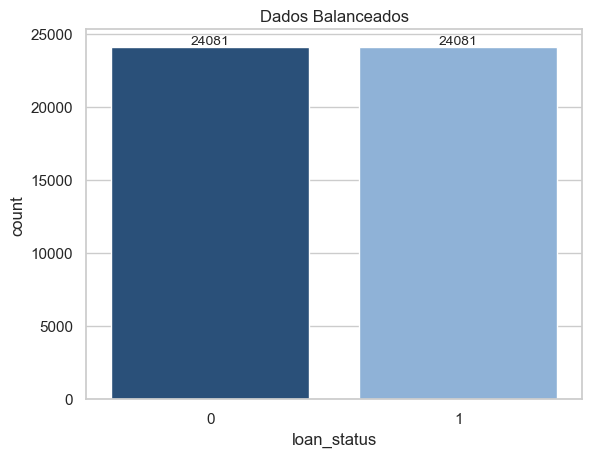

In [55]:
# Visualizando dados balanceados da variável alvo
ax = sns.countplot(x=dados_balanceados['loan_status'], palette=['#1d4f86', '#83b1e3'])
ax.bar_label(ax.containers[0], fontsize=10)
plt.title('Dados Balanceados')
plt.show()

#### Salvando Base Balanceada

In [56]:
dados_balanceados.to_csv('./dados/credit_risk_balanceado.csv', index=False)

### Pré-processamento dos Dados Originais

In [57]:
# Definindo base de atributos
X = dados_final.drop('loan_status', axis=1)

In [58]:
# Visualizando
X.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0.10,N,2
1,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,0.57,N,3
2,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,0.53,N,2
3,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,0.55,Y,4
4,21,9900,OWN,2.0,VENTURE,A,2500,7.14,0.25,N,2


In [59]:
# Definindo base da variável de objetivo
Y = dados_final.iloc[:,8].values

In [60]:
# Visualizando
Y

array([0, 1, 1, ..., 0, 0, 0], dtype=int64)

### Aplicando OneHotEncoder nos Dados Originais

In [61]:
# Criando o ColumnTransformer
onehotencoder_x = ColumnTransformer(transformers=[('OneHot', OneHotEncoder(), [0, 2, 4, 5, 9, 10])],
                                   remainder='passthrough')

In [62]:
# Aplicando a transformação
X_encoded = onehotencoder_x.fit_transform(X).toarray()

In [63]:
# Base codificada
X_encoded

array([[0.0000e+00, 1.0000e+00, 0.0000e+00, ..., 1.0000e+03, 1.1140e+01,
        1.0000e-01],
       [0.0000e+00, 0.0000e+00, 0.0000e+00, ..., 5.5000e+03, 1.2870e+01,
        5.7000e-01],
       [0.0000e+00, 0.0000e+00, 0.0000e+00, ..., 3.5000e+04, 1.5230e+01,
        5.3000e-01],
       ...,
       [0.0000e+00, 0.0000e+00, 0.0000e+00, ..., 5.0000e+03, 1.1260e+01,
        8.0000e-02],
       [0.0000e+00, 0.0000e+00, 0.0000e+00, ..., 5.8000e+03, 1.3160e+01,
        1.1000e-01],
       [0.0000e+00, 0.0000e+00, 0.0000e+00, ..., 1.7625e+04, 7.4900e+00,
        1.5000e-01]])

In [64]:
# Dimensões da base codificada
X_encoded.shape

(31025, 94)

### Escalonamento dos Valores nos Dados Originais

In [65]:
# Cria o StandardScaler
scaler_x_encoded = StandardScaler()

# Aplica a transformação
X_encoded = scaler_x_encoded.fit_transform(X_encoded)

### Divisão dos Dados Originais em Treinamento e Teste

In [66]:
# Criando base de Treino e Teste
x_treino, x_teste, y_treino, y_teste = train_test_split(X_encoded, Y, test_size=0.20, random_state=1)

In [67]:
# Dimensões da base de treino
x_treino.shape, y_treino.shape

((24820, 94), (24820,))

In [68]:
# Dimensões da base de teste
x_teste.shape, y_teste.shape

((6205, 94), (6205,))

### Pré-processamento dos Dados Balanceados

In [69]:
# Carregando dados
dados_balanceados = pd.read_csv('./dados/credit_risk_balanceado.csv')

In [70]:
# Definindo base de atributos
X_balanceado = dados_balanceados.drop('loan_status', axis=1)

In [71]:
# Definindo base da variável de objetivo
Y_balanceado = dados_balanceados.iloc[:,8].values

In [72]:
# Visualizando
Y_balanceado

array([0, 0, 0, ..., 1, 1, 1], dtype=int64)

### Aplicando OneHotEncoder nos Dados Balanceados

In [73]:
# Criando o ColumnTransformer
onehotencoder_x_balanceado = ColumnTransformer(transformers=[('OneHot', OneHotEncoder(), [0, 2, 4, 5, 9, 10])],
                                               remainder='passthrough')

In [74]:
# Aplicando a transformação
X_balanceado_encoded = onehotencoder_x.fit_transform(X_balanceado).toarray()

In [75]:
# Base codificada
X_balanceado_encoded

array([[0.000e+00, 1.000e+00, 0.000e+00, ..., 1.000e+03, 1.114e+01,
        1.000e-01],
       [0.000e+00, 0.000e+00, 0.000e+00, ..., 3.500e+04, 7.900e+00,
        3.000e-01],
       [0.000e+00, 0.000e+00, 0.000e+00, ..., 3.500e+04, 7.900e+00,
        2.900e-01],
       ...,
       [0.000e+00, 0.000e+00, 0.000e+00, ..., 8.000e+03, 1.292e+01,
        1.800e-01],
       [0.000e+00, 0.000e+00, 0.000e+00, ..., 7.000e+03, 1.099e+01,
        1.200e-01],
       [0.000e+00, 0.000e+00, 0.000e+00, ..., 1.050e+04, 7.660e+00,
        2.500e-01]])

### Escalonamento dos Valores dos Dados Balanceados

In [76]:
# Cria o StandardScaler
scaler_x_balanceado_encoded = StandardScaler()

# Aplica a transformação
X_balanceado_encoded = scaler_x_balanceado_encoded.fit_transform(X_balanceado_encoded)

In [77]:
# Visualizando a primeira linha
X_balanceado_encoded[0]

array([-0.02232861,  4.60152509, -0.36962145, -0.37186765, -0.35420961,
       -0.31985475, -0.28209042, -0.25919817, -0.24470358, -0.2312102 ,
       -0.19806155, -0.18805163, -0.16793388, -0.16128043, -0.14665178,
       -0.13379574, -0.1278016 , -0.12011677, -0.10054382, -0.09809198,
       -0.09390642, -0.07996363, -0.07674454, -0.07091622, -0.06505984,
       -0.05881005, -0.05018647, -0.05101138, -0.04955887, -0.04204756,
       -0.03815159, -0.03350335, -0.03531783, -0.02954349, -0.02989344,
       -0.02657912, -0.01705198, -0.02411865, -0.02088585, -0.00911372,
       -0.02735025, -0.7176715 , -0.06209681,  3.95499911, -1.21488303,
       -0.46445766,  2.11097463, -0.36776845, -0.50057092, -0.44259244,
       -0.42988027, -0.60615414,  1.55582666, -0.49449801, -0.46465587,
       -0.22348246, -0.11512701, -0.0653809 ,  0.52746435, -0.52746435,
        2.04992768, -0.4771285 , -0.48056859, -0.24470358, -0.24197526,
       -0.24317482, -0.2417829 , -0.24403566, -0.23994949, -0.11

### Divisão dos Dados Balanceados em Treinamento e Teste

In [78]:
# Criando base de Treino e Teste
x_treino_balanceado, x_teste_balanceado, y_treino_balanceado, y_teste_balanceado = train_test_split(X_balanceado_encoded, Y_balanceado, test_size=0.20, random_state=1)

In [79]:
# Dimensões da base de treino
x_treino_balanceado.shape, y_treino_balanceado.shape

((38529, 94), (38529,))

In [80]:
# Dimensões da base de teste
x_teste_balanceado.shape, y_teste_balanceado.shape

((9633, 94), (9633,))

## Salvando as Bases Processadas

In [81]:
# Base original
with open('./dados/credit_risk.pkl', 'wb') as arquivo:
    pickle.dump([x_treino, x_teste, y_treino, y_teste], arquivo)

In [82]:
# Base balanceada
with open('./dados/credit_risk_balanceada.pkl', 'wb') as arquivo:
    pickle.dump([x_treino_balanceado, x_teste_balanceado, y_treino_balanceado, y_teste_balanceado], arquivo)

## Carregando Bases

### Carregando Base de Dados Original Processada

In [83]:
# Carregando base processada
with open('./dados/credit_risk.pkl', 'rb') as arquivo:
    x_treino, x_teste, y_treino, y_teste = pickle.load(arquivo)

In [84]:
# Treino
x_treino.shape, y_treino.shape

((24820, 94), (24820,))

In [85]:
# Teste
x_teste.shape, y_teste.shape

((6205, 94), (6205,))

### Carregando Base de Dados Balanceada Processada

In [86]:
# Carregando base processada
with open('./dados/credit_risk_balanceada.pkl', 'rb') as arquivo:
    x_treino_balanceado, x_teste_balanceado, y_treino_balanceado, y_teste_balanceado = pickle.load(arquivo)

In [87]:
# Treino
x_treino_balanceado.shape, y_treino_balanceado.shape

((38529, 94), (38529,))

In [88]:
# Teste
x_teste_balanceado.shape, y_teste_balanceado.shape

((9633, 94), (9633,))

## Algoritmos de Machine Learning

Serão empregados quatro algoritmos distintos durante o treinamento dos modelos:

1. [Random Forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier)
2. [SVM](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC)
3. [Regressão Logística](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression)
4. [Redes Neurais Artificiais](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html#sklearn.neural_network.MLPClassifier)

A abordagem adotada consistirá na aplicação da técnica de validação cruzada para analisar o desempenho dos quatro algoritmos tanto com dados normais quanto com dados balanceados. Dessa forma, serão obtidos oito modelos. Para avaliar cada modelo, serão utilizadas as seguintes métricas:

1. Accuracy
2. Precisão
3. Recall

Ao final, os valores obtidos por cada modelo serão avaliados.

### Treinamento dos modelos

In [89]:
# Criando classificadores
random_forest = RandomForestClassifier()
svm = SVC()
logistic = LogisticRegression()
rna = MLPClassifier()

In [90]:
# Aplicando validação cruzada nos dados balanceados
random_forest_balanceado = validacao_cruzada(random_forest, x_treino_balanceado, y_treino_balanceado)
svm_balanceado = validacao_cruzada(svm, x_treino_balanceado, y_treino_balanceado)
logistic_balanceado = validacao_cruzada(logistic, x_treino_balanceado, y_treino_balanceado)
rna_balanceado = validacao_cruzada(rna, x_treino_balanceado, y_treino_balanceado)

In [91]:
# Aplicando validação cruzada nos dados originais
random_forest_normal = validacao_cruzada(random_forest, x_treino, y_treino)
svm_normal = validacao_cruzada(svm, x_treino, y_treino)
logistic_normal = validacao_cruzada(logistic, x_treino, y_treino)
rna_normal = validacao_cruzada(rna, x_treino, y_treino)

### Análise dos Resultados Obtidos

In [150]:
# DataFrame com valores de accuracy dos modelos balanceados
accuracy_balanceado_df = pd.DataFrame({'RandomForest_balanceado':random_forest_balanceado['accuracy'],
                                       'SVM_balanceado':svm_balanceado['accuracy'],
                                       'RegressaoLogistica_balanceado':logistic_balanceado['accuracy'],
                                       'RNA_balanceado':rna_balanceado['accuracy']})

In [151]:
# DataFrame com valores de accuracy dos modelos normais
accuracy_normal_df = pd.DataFrame({'RandomForest_normal':random_forest_normal['accuracy'],
                                       'SVM_normal':svm_normal['accuracy'],
                                       'RegressaoLogistica_normal':logistic_normal['accuracy'],
                                       'RNA_normal':rna_normal['accuracy']})

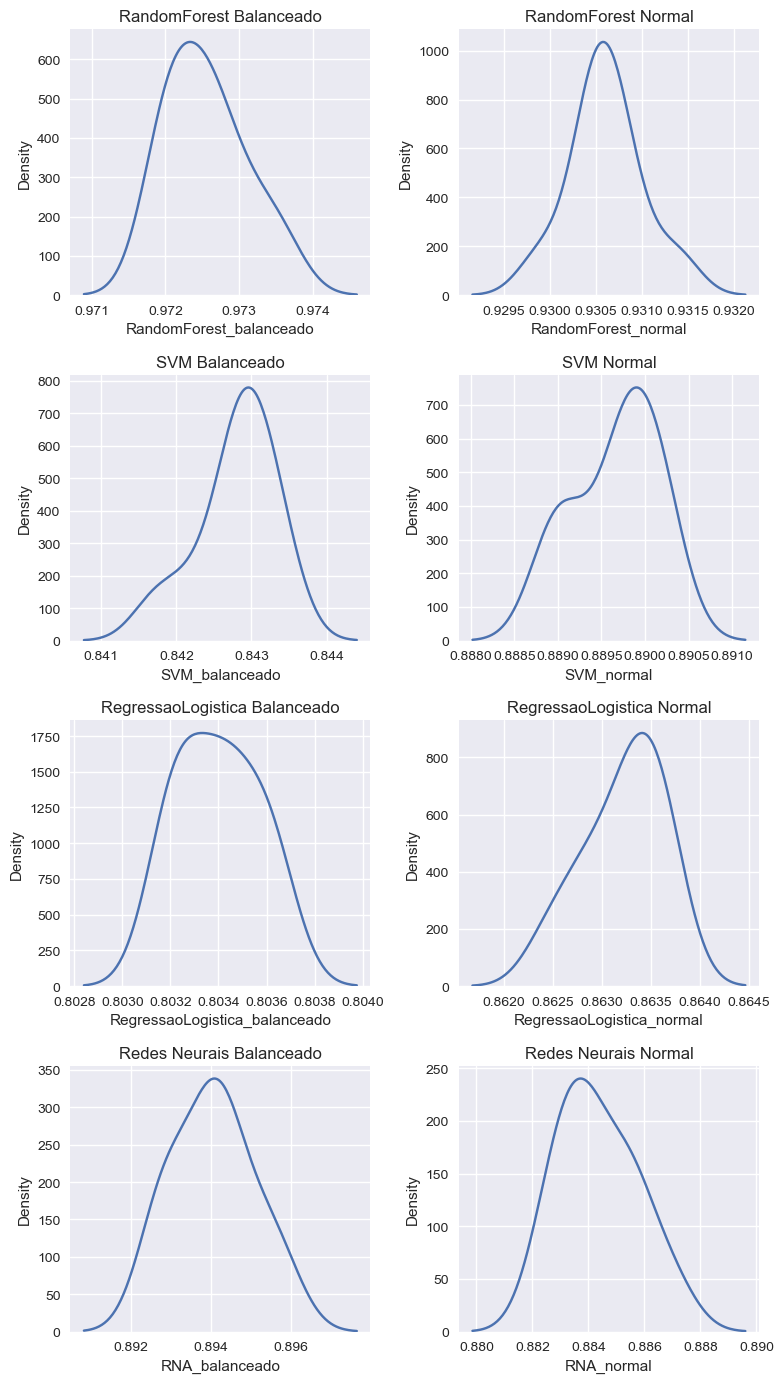

In [164]:
# Visualizando distribuição dos modelos
fig, axs = plt.subplots(4, 2, figsize=(8, 14))

sns.kdeplot(accuracy_balanceado_df['RandomForest_balanceado'], ax=axs[0,0])
axs[0,0].set_title('RandomForest Balanceado')
sns.kdeplot(accuracy_normal_df['RandomForest_normal'], ax=axs[0,1])
axs[0,1].set_title('RandomForest Normal')

sns.kdeplot(accuracy_balanceado_df['SVM_balanceado'], ax=axs[1,0])
axs[1,0].set_title('SVM Balanceado')
sns.kdeplot(accuracy_normal_df['SVM_normal'], ax=axs[1,1])
axs[1,1].set_title('SVM Normal')

sns.kdeplot(accuracy_balanceado_df['RegressaoLogistica_balanceado'], ax=axs[2,0])
axs[2,0].set_title('RegressaoLogistica Balanceado')
sns.kdeplot(accuracy_normal_df['RegressaoLogistica_normal'], ax=axs[2,1])
axs[2,1].set_title('RegressaoLogistica Normal')

sns.kdeplot(accuracy_balanceado_df['RNA_balanceado'], ax=axs[3,0])
axs[3,0].set_title('Redes Neurais Balanceado')
sns.kdeplot(accuracy_normal_df['RNA_normal'], ax=axs[3,1])
axs[3,1].set_title('Redes Neurais Normal')

plt.tight_layout()
plt.show()

>Ambos os modelos, treinados com dados balanceados e dados normais, exibem uma distribuição normal. Isso indica que as previsões tendem a se agrupar em torno da média, proporcionando uma compreensão visual da consistência e padrões de comportamento dos modelos em diferentes conjuntos de dados.

In [96]:
# Avaliando as métricas dos modelos
resumo = pd.DataFrame(
    {'Modelos': ['accuracy', 'precision', 'recall'],
            'random_forest_balanceado': [
                np.mean(random_forest_balanceado['accuracy']),
                np.mean(random_forest_balanceado['precision']),
                np.mean(random_forest_balanceado['recall'])],
            'random_forest_normal': [
                np.mean(random_forest_normal['accuracy']),
                np.mean(random_forest_normal['precision']),
                np.mean(random_forest_normal['recall'])],
            'svm_balanceado': [
                np.mean(svm_balanceado['accuracy']),
                np.mean(svm_balanceado['precision']),
                np.mean(svm_balanceado['recall'])],
            'svm_normal': [
                np.mean(svm_normal['accuracy']),
                np.mean(svm_normal['precision']),
                np.mean(svm_normal['recall'])],
            'logistic_balanceado': [
                np.mean(logistic_balanceado['accuracy']),
                np.mean(logistic_balanceado['precision']),
                np.mean(logistic_balanceado['recall'])],
            'logistic_normal': [
                np.mean(logistic_normal['accuracy']),
                np.mean(logistic_normal['precision']),
                np.mean(logistic_normal['recall'])],
            'rna_balanceado': [
                np.mean(rna_balanceado['accuracy']),
                np.mean(rna_balanceado['precision']),
               np.mean(rna_balanceado['recall'])],
            'rna_normal': [
                np.mean(rna_normal['accuracy']),
                np.mean(rna_normal['precision']),
                np.mean(rna_normal['recall'])]}).set_index('Modelos')


resumo = resumo.transpose()
resumo.style.applymap(lambda x: 'background-color: #abcaec' if x >= 0.80 else '')

Modelos,accuracy,precision,recall
random_forest_balanceado,0.972558,0.973715,0.971432
random_forest_normal,0.930608,0.964429,0.715700
svm_balanceado,0.842802,0.873231,0.802655
svm_normal,0.889662,0.891696,0.576024
logistic_balanceado,0.803397,0.814617,0.786425
logistic_normal,0.863219,0.764566,0.560138
rna_balanceado,0.894056,0.885312,0.905910
rna_normal,0.884363,0.773490,0.682797


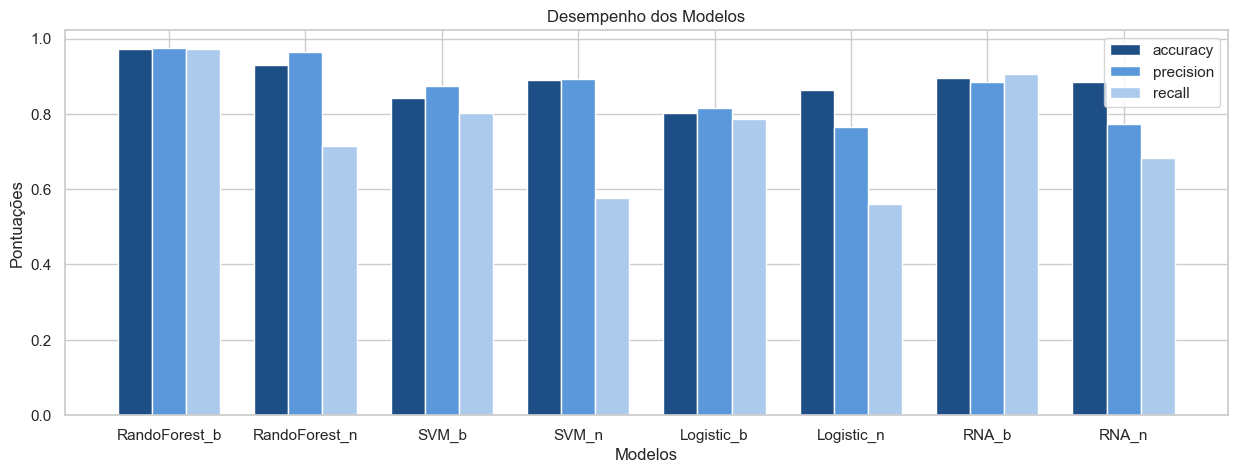

In [97]:
# Criando um gráfico para visualização
fig, ax = plt.subplots(figsize=(15, 5))

# Adiciona barras para cada métrica
largura_barra = 0.25
barra_1 = range(len(resumo))
barra_2 = [pos + largura_barra for pos in barra_1]
barra_3 = [pos + largura_barra for pos in barra_2]

# Cores das barras
cores = {'accuracy':'#1d4f86', 'precision':'#5a98db', 'recall':'#abcaec'}

ax.bar(barra_1, resumo['accuracy'], width=largura_barra, label='accuracy', color=cores['accuracy'])
ax.bar(barra_2, resumo['precision'], width=largura_barra, label='precision', color=cores['precision'])
ax.bar(barra_3, resumo['recall'], width=largura_barra, label='recall', color=cores['recall'])

# Adiciona rótulos
ax.set_xticks([pos + largura_barra for pos in barra_1])
ax.set_xticklabels(['RandoForest_b', 'RandoForest_n', 'SVM_b', 'SVM_n',
                   'Logistic_b', 'Logistic_n', 'RNA_b', 'RNA_n'])
ax.set_xlabel('Modelos')
ax.set_ylabel('Pontuações')
ax.set_title('Desempenho dos Modelos')
ax.legend()
plt.show()

Analisando a tabela de pontuações e o gráfico, podemos extrair as seguintes informações:

1. Acurácia (Accuracy):
- Os modelos `random_forest_balanceado` e `random_forest_normal` alcançaram as maiores taxas de acurácia, aproximadamente 97.25% e 93.06% respectivamente, indicando uma taxa geral de classificação correta muito alta.
    
- Em contraste, o modelo `svm_balanceado` e `logistic_balanceado` tiveram acurácias significativamente inferiores, em torno de 80-84%, sugerindo uma menor precisão global.

2. Precisão (Precision):
- Os modelos `random_forest_balanceado` e `random_forest_normal` apresentaram as maiores valores de precisão, com uma pontuação de cerca de 97.3% e 96.4% respectivamente. Isso destaca a capacidade destes modelos em minimizar falsos positivos.
    
- `logistic_normal` e `rna_normal` têm as precisões mais baixas entre os modelos, apresentando respectivamente 76.46% e 77.34%, indicando uma maior propensão a gerar falsos positivos.

3. Revocação (Recall):
- Os modelos `random_forest_balanceado` e `rna_balanceado` se destacam na métrica de revocação, aproximadamente 97.14% e 90.59% respectivamente, sugerindo que ambos os modelos tem uma habilidade superior em identificar verdadeiros positivos.
    
- Os modelos `svm_normal` e `logistic_normal` exibem as pontuações mais baixas de revocação, 57.6% e 56% respectivamente, indicando uma capacidade ruim de capturar a maioria dos verdadeiros positivos.

Em geral, ao interpretar as informações fornecidas pela tabela e gráfico, fica evidente que os `dados balanceados` apresentaram melhores resultados considerando as três métricas utilizadas. Entre os modelos, podemos destacar o `random_forest_balanceado` que alcançou altas pontuações em todas as métricas.

## Teste de Hipóteses ANOVA e Tukey

### ANOVA

>A ANOVA unidirecional testa a hipótese nula de que dois ou mais grupos têm a mesma média populacional. O teste é aplicado a amostras de dois ou mais grupos, possivelmente com tamanhos diferentes.

In [154]:
# ANOVA teste
_, p = f_oneway(random_forest_balanceado['accuracy'],svm_balanceado['accuracy'], logistic_balanceado['accuracy'],
                rna_balanceado['accuracy'],random_forest_normal['accuracy'],svm_normal['accuracy'], 
                logistic_normal['accuracy'],rna_normal['accuracy'])

# Definindo alpha em 0.05, indica que o teste terá uma confiabilidade de 95%
alpha = 0.05

# Rejeitando a hipótese nula
if p <= alpha:
    print('Hipótese nula rejeitada. Dados são diferentes')
else:
    print('Hipótese alternativa rejeitada. Resultados são iguais')

Hipótese nula rejeitada. Dados são diferentes


>Se os dados fossem iguais, poderiamos usar qualquer um dos algoritmos, mas como são diferentes precisamos identificar qual é de fato o melhor algoritmo.

### Tukey

>O teste de Tukey efetua uma comparação de pares de médias para um conjunto de amostras.

In [159]:
# preparando base para teste
lista = [
    model + '_' + condition
    for model in ['random', 'svm', 'logistic', 'rna']
    for condition in ['balanceado', 'normal']
    for _ in range(10)
]

resultado_algoritmos = {'Accuracy':np.concatenate([random_forest_balanceado['accuracy'], random_forest_normal['accuracy'],
                                                  svm_balanceado['accuracy'], svm_normal['accuracy'],
                                                  logistic_balanceado['accuracy'], logistic_normal['accuracy'],
                                                  rna_balanceado['accuracy'], rna_normal['accuracy']]),
                       'Algoritmo':lista}
resultado_algoritmos = pd.DataFrame(resultado_algoritmos)

In [161]:
# Aplicando teste de multiplas comparações
compara_algoritmos = MultiComparison(resultado_algoritmos['Accuracy'], resultado_algoritmos['Algoritmo'])

In [162]:
# Teste estatístico
teste_estatistico = compara_algoritmos.tukeyhsd()
print(teste_estatistico)

            Multiple Comparison of Means - Tukey HSD, FWER=0.05            
       group1             group2      meandiff p-adj  lower   upper  reject
---------------------------------------------------------------------------
logistic_balanceado   logistic_normal   0.0598   0.0  0.0588  0.0608   True
logistic_balanceado random_balanceado   0.1692   0.0  0.1682  0.1702   True
logistic_balanceado     random_normal   0.1272   0.0  0.1262  0.1282   True
logistic_balanceado    rna_balanceado   0.0907   0.0  0.0897  0.0917   True
logistic_balanceado        rna_normal    0.081   0.0    0.08   0.082   True
logistic_balanceado    svm_balanceado   0.0394   0.0  0.0384  0.0404   True
logistic_balanceado        svm_normal   0.0863   0.0  0.0853  0.0873   True
    logistic_normal random_balanceado   0.1093   0.0  0.1083  0.1103   True
    logistic_normal     random_normal   0.0674   0.0  0.0664  0.0684   True
    logistic_normal    rna_balanceado   0.0308   0.0  0.0298  0.0318   True
    logistic

>Todos os modelos são estatisticamente diferentes.

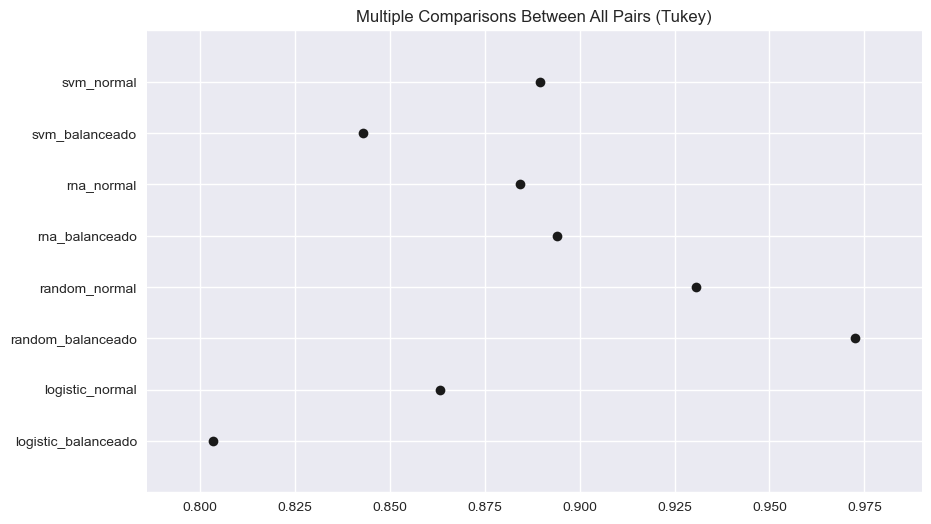

In [163]:
# Visualizando o melhor modelo
teste_estatistico.plot_simultaneous()
plt.show()

Após conduzir o teste de Tukey nas métricas de avaliação de acurácia derivadas da aplicação de diversos algoritmos nos conjuntos de dados original e balanceado, torna-se evidente a existência de uma diferença substancial no desempenho entre tais algoritmos.

A análise gráfica revela que o `RandomForestClassifier` sobressai-se notavelmente ao empregar a base de dados balanceada, enquanto, em contrapartida, a `LogisticRegression` apresenta o menor desempenho nesse contexto. Diante desse cenário, a escolha do algoritmo `RandomForestClassifier` ao utilizar a base de dados balanceada é plenamente justificada para implementação.

## Tuning dos Parâmetros com Grid Search

Agora que determinamos o modelo a ser aplicado, é necessário realizar alguns ajustes. Anteriormente, o modelo `RandomForest` foi executado com suas configurações padrão. Para aprimorar os resultados, faremos um ajuste fino nos hiperparâmetros utilizando a técnica de [Grid Search](https://scikit-learn.org/stable/modules/grid_search.html#exhaustive-grid-search) nos seguintes parâmetros:

- criterion
- n_estimators
- min_samples_split
- min_samples_leaf


In [165]:
# Concatenando base de treino e teste balanceada
X_credit = np.concatenate((x_treino_balanceado, x_teste_balanceado), axis=0)
y_credit = np.concatenate((y_treino_balanceado, y_teste_balanceado), axis=0)

# Dimensões
X_credit.shape, y_credit.shape

((48162, 94), (48162,))

In [166]:
# Hiperparâmetros
parametros = {
    'criterion':['gini', 'entropy'],
    'n_estimators':[10, 50, 100, 200],
    'min_samples_split':[2, 5, 10],
    'min_samples_leaf':[1, 5, 10]
}

In [167]:
# Criando objeto GridSearchCV
grid_search = GridSearchCV(estimator=RandomForestClassifier(), param_grid=parametros)

# Treinando modelo
grid_search.fit(X_credit, y_credit)

# Melhores hiperparâmetros
melhores_parametros = grid_search.best_params_

# Melhor acurácia
melhor_resultado = grid_search.best_score_

# Visualizando os resultados
print(melhores_parametros)
print(melhor_resultado)

{'criterion': 'entropy', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
0.9827042255597712


A melhor configuração de hiperparâmetros resultou nos seguintes valores:

- criterion: entropy
- n_estimators: 200
- min_samples_split: 2
- min_samples_leaf: 1

A precisão obtida foi de **98.27%**.

### Criando Modelo com as Definições dos Hiperparâmetros

In [171]:
# Criando modelo
modelo = RandomForestClassifier(criterion='entropy', n_estimators=200, min_samples_split=2,
                                min_samples_leaf=1, random_state=1)
modelo.fit(x_treino_balanceado, y_treino_balanceado)

# Criando previsões
previsoes = modelo.predict(x_teste_balanceado)

In [172]:
# Acuracia do modelo
print('Acurácia:', round(accuracy_score(y_teste_balanceado, previsoes), 2))

Acurácia: 0.98


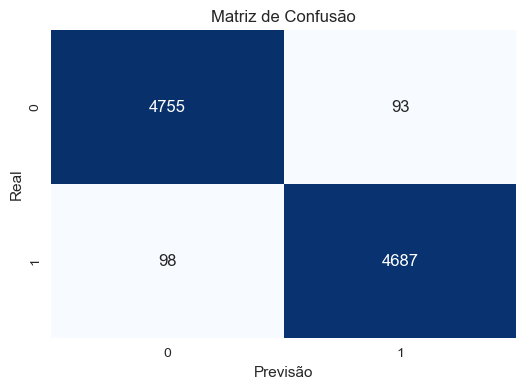

In [173]:
# Matriz de confusão
cm = confusion_matrix(y_teste_balanceado, previsoes)

# Grafico
matriz_confusao(cm)

>Na matriz de confusão, notamos que o modelo acertou a classificação de **4.755** registros como **(0)**, indicando que esses clientes pagaram o empréstimo. No entanto, houve **93** casos em que o modelo errou essa classificação. Quanto aos registros de clientes que não pagaram **(1)**, o modelo acertou a classificação de **4.687** registros e cometeu apenas **98** erros.

In [174]:
# Estatíticas do modelo
print(classification_report(y_teste_balanceado, previsoes))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      4848
           1       0.98      0.98      0.98      4785

    accuracy                           0.98      9633
   macro avg       0.98      0.98      0.98      9633
weighted avg       0.98      0.98      0.98      9633



No tunning dos hiperparâmetros foi indicado que o melhor valor para o `n_estimators` seria 100, mas testando com 200 obtivemos um valor interessante nas métricas estátisticas.

Conforme o `classification report` tivemos os seguintes resultados para cada métrica das classes 0 e 1:

- Precision:
    - Classe 0 (0): 98% dos casos classificados como 0 foram realmente da classe 0.
    - Classe 1 (1): 98% dos casos classificados como 1 foram realmente da classe 1.

- Recall (Revocação ou Sensibilidade):
    - Classe 0 (0): O modelo identificou corretamente 98% de todos os casos verdadeiros da classe 0.
    - Classe 1 (1): O modelo identificou corretamente 98% de todos os casos verdadeiros da classe 1.

- F1-Score:
    - Classe 0 (0): O valor médio harmônico entre precisão e recall para a classe 0 é 98%, indicando um bom equilíbrio entre precisão e sensibilidade.
    - Classe 1 (1): O valor médio harmônico entre precisão e recall para a classe 1 é 98%, também sugerindo um equilíbrio eficaz entre precisão e sensibilidade.

Essas métricas indicam que o modelo possui um desempenho robusto para ambas as classes, com alta precisão, recall e F1-score. A alta pontuação em todas essas métricas sugere que o modelo é capaz de fazer previsões precisas e identificar efetivamente as duas classes no conjunto de dados.

### Salvando Classificador Treinado

In [175]:
pickle.dump(modelo, open('./modelos/random_forest_credit.sav', 'wb'))

### Testando Classificador

In [176]:
# Acessando modelo
random_forest = pickle.load(open('./modelos/random_forest_credit.sav', 'rb'))

In [182]:
# Selecionando registro da base
novo_registro = X_credit[0] # linha de registro
novo_registro = np.reshape(novo_registro, (1, -1))

# previsão
previsao = random_forest.predict(novo_registro)
previsao = previsao[0]

if previsao == 0:
    print(f'Resultado foi: {previsao}. O cliente paga o empréstimo.')
else:
    print(f'Resultado foi: {previsao}. O cliente não paga o empréstimo.')

Resultado foi: 1. O cliente não paga o empréstimo.


In [183]:
# Verificando se o modelo realmente classificou correto
print(f'O resultado da previsão: {previsao}')
print(f'O valor real: {y_credit[0]}')

O resultado da previsão: 1
O valor real: 1


### Criando Modelo para Previsão do Risco do Empréstimo

In [5]:
# Carregando base de dados
df = pd.read_csv('./dados/credit_risk_transformada.csv')

## Balanceando a base

# Separando dados de maioria e minoria
status_a = df[df['loan_grade'] == 'A']
status_b = df[df['loan_grade'] == 'B']
status_c = df[df['loan_grade'] == 'C']
status_d = df[df['loan_grade'] == 'D']
status_e = df[df['loan_grade'] == 'E']
status_f = df[df['loan_grade'] == 'F']
status_g = df[df['loan_grade'] == 'G']

# Definindo valor para n_samples
n_samples = len(status_a)
n_samples

# Balanceamento do atributo
status_b_balanceada = resample(status_b, replace=True, n_samples=n_samples)
status_c_balanceada = resample(status_c, replace=True, n_samples=n_samples)
status_d_balanceada = resample(status_d, replace=True, n_samples=n_samples)
status_e_balanceada = resample(status_e, replace=True, n_samples=n_samples)
status_f_balanceada = resample(status_f, replace=True, n_samples=n_samples)
status_g_balanceada = resample(status_g, replace=True, n_samples=n_samples)

# Base balanceada
df_balanceado = pd.concat([status_a, status_b_balanceada, status_c_balanceada,status_d_balanceada,
                          status_e_balanceada,status_f_balanceada,status_g_balanceada])

In [6]:
# Separando as variaveis
X = df_balanceado.drop(['loan_status', 'loan_grade'], axis=True)
y = df_balanceado.iloc[:,5].values

## Normalização dos dados

# Criando o ColumnTransformer
onehotencoder = ColumnTransformer(transformers=[('OneHot', OneHotEncoder(), [0, 2, 4, 8])],
                                               remainder='passthrough')

x_enconded = onehotencoder.fit_transform(X).toarray()

# Cria o StandardScaler
scaler = StandardScaler()

# Aplica a transformação
x_credit = scaler.fit_transform(x_enconded)

In [7]:
# Separando base de teste e treino
x_treino, x_teste, y_treino, y_teste = train_test_split(x_credit, y, test_size=0.2, random_state=1)

# Criando modelo
modelo = RandomForestClassifier(criterion='entropy', n_estimators=200, min_samples_split=2,
                                min_samples_leaf=1, random_state=1)
modelo.fit(x_treino, y_treino)

# Criando previsões
previsoes = modelo.predict(x_teste)

# Acuracia do modelo
print('Acurácia:', accuracy_score(y_teste, previsoes))

Acurácia: 0.9710726643598616


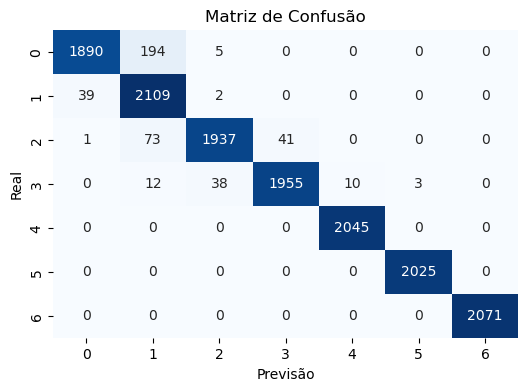

In [8]:
# Matriz de confusão
cm = confusion_matrix(y_teste, previsoes)

# Grafico
matriz_confusao(cm)

In [9]:
# Estatíticas do modelo
print(classification_report(y_teste, previsoes))

              precision    recall  f1-score   support

           A       0.98      0.90      0.94      2089
           B       0.88      0.98      0.93      2150
           C       0.98      0.94      0.96      2052
           D       0.98      0.97      0.97      2018
           E       1.00      1.00      1.00      2045
           F       1.00      1.00      1.00      2025
           G       1.00      1.00      1.00      2071

    accuracy                           0.97     14450
   macro avg       0.97      0.97      0.97     14450
weighted avg       0.97      0.97      0.97     14450



In [10]:
# Salvando modelo
pickle.dump(modelo, open('./modelos/modelo_grau_risco.sav', 'wb'))

>O modelo de classificação apresenta um desempenho sólido, com altas precisões, recalls e F1-scores para todas as classes (A a G). A acurácia geral é de 97%, indicando que o modelo classifica corretamente a maioria das instâncias. As métricas macro e ponderadas sugerem um bom equilíbrio entre as classes, considerando a importância relativa e o desequilíbrio no número de instâncias por classe. Em resumo, o modelo é eficaz e robusto na tarefa de classificação.

## Conclusão

Diante do desafio representado pela taxa de inadimplência de aproximadamente **22%** que assolava a empresa, a aplicação eficaz do modelo de machine learning, que ostenta uma impressionante taxa de acerto de **98%** em suas previsões, emerge como uma promissora solução. 

Ao projetar a possível redução da taxa de inadimplência para **2%**, observamos uma transformação significativa no cenário financeiro. Em números concretos, considerando um faturamento de **1.000.000**, a atual perda seria de aproximadamente **220.000** proveniente da proporção de clientes inadimplentes, essa perda pode ser drasticamente mitigada para **20.000** com a implementação do modelo.

Essa notável redução de aproximadamente **91%**, não apenas ressalta a eficácia do novo sistema, mas também destaca sua capacidade de fortalecer substancialmente a saúde financeira da empresa. A estimativa de lucros que era de **780.000** passou a ser de **980.000** um ganho de **200.000**.

Portanto, a adoção desse modelo de machine learning não apenas representa uma resposta eficaz aos desafios de inadimplência, mas também promete um impacto positivo considerável nas finanças da empresa e posicionando-a em um caminho mais seguro e lucrativo para o futuro.